### basic processing of a voice signal
* STFT
* F0
* MFCC


Energy of a discrete-time signal

$ E = \sum_{n= -\infty}^{\infty} | x(n)|^{2}$

$X(k) = \sum_{n=0}^{N-1}x(n) e^{-j\frac{2\pi}{N}} , k = 0,1,...,N-1$

Euler's formula

$e^{jx} = cos(x) + j sin(x)$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Audio
import librosa
import librosa.display
import scipy

plt.rcParams['figure.figsize'] = [12, 5]

In [3]:
data_dir = '/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data/voice_clip_selected/'

import os
os.chdir(data_dir)
voice_clip_meta_data = pd.read_csv("voice_clip_meta_data.csv")


We use the same selection of the voice clips.

In [4]:
audiofile = [
    "common_voice_en_487076.mp3" # eighties female
    ,"common_voice_en_20661764.mp3" # eighties male
    ,"common_voice_en_1716.mp3" # seventies female
    ,"common_voice_en_20002554.mp3" # sixties male
    ,"common_voice_en_30282850.mp3" # fifties female
    ,"common_voice_en_39750682.mp3" # twenties female
    ,"common_voice_en_37110064.mp3"  # teen male
    ,"common_voice_en_31267867.mp3" # teen female
    ]

## More about f0

### handling sample rate
* at first, I thought we could resample to librosa's default sample rate, 22050
* looking at the result of native sampling rates in the above, it may seem to be safe to resample clips into 22050 throughout our project, as librosa doc commented that 22050 is sufficient for music
* still, we do not know if they are sufficient for our purpose, but doing this can avoid sample rate mismatch:
 - when we forgot to enter sample rate in librosa functions that need sample rate, librosa uses 22050 as default, the mismatch of sample rate in computation could potentially generate wrong results without us being aware

#### important find 
 * it turns out that sr parameter to pYIN (f0) computation is important
 * when librosa load with resample to 22050, and we use 22050 for pYin, it yields higher f0 
 * for the first clip in voice list, mean f0 => 151, with resampled to 22050
 * when librosa load native sample rate of the clips, and feed to native sr to pYin, f0 is lower => 148
 * and the lower f0 is more reasonable for the male seventies by spot checking
 * accidental find: if we load native sample rate, but run pYin with default sr=22050, it will yield a much lower f0 => 121
 * conclusion: we will have to use native sampling rate for computing f0

#### sample rate could render entire clip being determined as unvoiced
 * clips that gave errors when computing f0, with resample rate to 22050
 * voice_clip_meta_data[115], 'common_voice_en_26324576.mp3' ,  the entire clip is consider unvoiced
 * for this case, we make the function "get_f0_stats" to return nan
 * then: for the same clipe, voice_clip_meta_data[115], 'common_voice_en_26324576.mp3'
 * when we use clip's native sample rate, i.e., do librosa.load(file, sr=None), we will be able to compute f0 
 * conclusion: we will keep using each clip's native sample rate

 * stats.describe(f0[voiced_flag],nan_policy='propagate')._asdict() can not handle empty array, when f0[voiced_clip] is empty
* use np.any(f0[voiced_flag]) to check if the array is empty
* return np.nan when empty

* fill_na = None in f0 computation will result in f0 with interpolated values
* but this could be misleading for unvoiced segments, then need to use voiced_flag to select the true f0 in the result 
* f0, voiced_flag, voiced_probs = librosa.pyin(voice_clip_meta_data[0], fmin=50, fmax=1000, fill_na=None)
* dr = stats.describe(f0[voiced_flag])._asdict()
* pd.DataFrame([dr], columns = dr.keys())

### experiment: impact of sample rate on f0 features

In [5]:
from scipy import stats
def get_f0_stats(x, sr): # need to use native sample rate
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, sr=sr,fmin=50, fmax=1000, fill_na=None)
    if np.any(f0[voiced_flag]) == False:
        return [np.nan,np.nan,np.nan,np.nan]
    else:
        dr = stats.describe(f0[voiced_flag],nan_policy='propagate')._asdict()
        return [dr['mean'], dr['variance'], dr['skewness'], dr['kurtosis']]

In [6]:
x,sr=librosa.load(data_dir+voice_clip_meta_data.iloc[0].path,sr=None)
f0, voiced_flag, voiced_probs = librosa.pyin(x, sr = sr, fmin=50, fmax=1000, fill_na=None)
dr = stats.describe(f0[voiced_flag])._asdict()
pd.DataFrame([dr], columns = dr.keys())

,nobs,minmax,mean,variance,skewness,kurtosis
0,535,"(98.85140203528961, 244.81070866093103)",148.104476,802.239675,0.944129,1.336574


In [7]:
x, sr = librosa.load(data_dir+voice_clip_meta_data.iloc[0].path,sr=None) # native sample rate
print(sr, get_f0_stats(x,sr)) # matching sample rate
x, sr = librosa.load(data_dir+voice_clip_meta_data.iloc[0].path) # resampled to 22050 by librosa default
print(sr, get_f0_stats(x,sr)) # default 22050
x, sr = librosa.load(data_dir+audiofile[4],sr=None) #native sample rate
print(sr, get_f0_stats(x,sr=22050)) # mismatch sample rate, the clip has sample rate 32000



48000 [148.1044764958254, 802.2396754158585, 0.9441290550586952, 1.3365737904582096]
22050 [151.51434007913196, 1150.4067167396076, 1.404116556780767, 2.796149761900754]
32000 [121.05364048201304, 402.34893503972097, 1.3036370778921273, 2.200280173424493]


In [8]:
x, sr = librosa.load(data_dir+audiofile[4],sr=None) # native sample rate
print(sr, get_f0_stats(x,sr)) # matching sample rate
x, sr = librosa.load(data_dir+audiofile[4]) # resampled to 22050 by librosa default
print(sr, get_f0_stats(x,sr)) # default 22050
x, sr = librosa.load(data_dir+audiofile[4],sr=None) #native sample rate
print(sr, get_f0_stats(x,sr=22050)) # mismatch sample rate, the clip has sample rate 32000


32000 [175.09835300742748, 833.9860430206336, 1.3943870116326897, 2.4677535344244665]
22050 [175.56393262327688, 864.9884671063597, 1.385263353694781, 2.3574714352939363]
32000 [121.05364048201304, 402.34893503972097, 1.3036370778921273, 2.200280173424493]


In [8]:
x, sr = librosa.load(data_dir+audiofile[4],sr=None) 
print(x.shape, sr)

(236160,) 32000


Instead of using plt.plot() to plot the wave data as we did before, we can use librosa's function librosa.display.waveshow(), which shows the x axis as time.

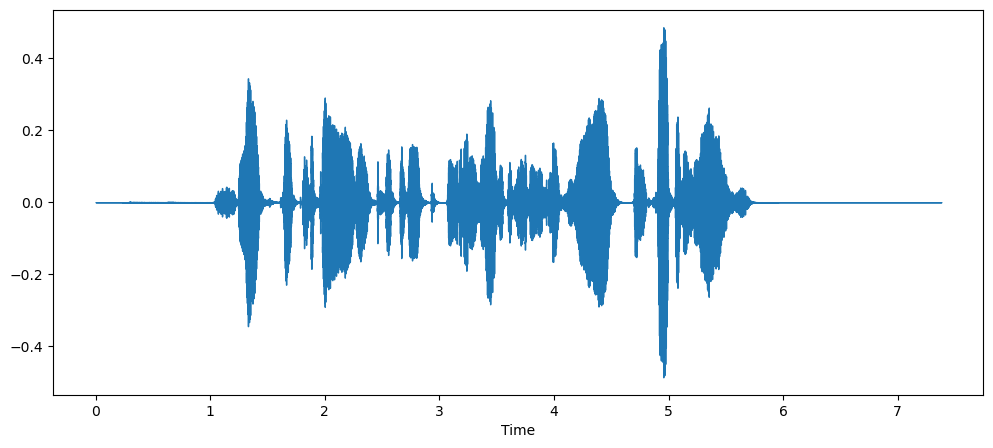

In [9]:
librosa.display.waveshow(x, sr=sr)

## FFT

Looking at a toy example

In [10]:
x=np.array([2,4,-1,6])
X=np.linspace(0,1j, num=4)
X[0] = 2+4+(-1)+6
X[1] = 2+(-4j)+1+6j
X[2] = 2+(-4)+(-1)-6
X[3] = 2 +(4j)+1-6j
X

array([11.+0.j,  3.+2.j, -9.+0.j,  3.-2.j])

In [11]:
np.fft.fft(x)

array([11.+0.j,  3.+2.j, -9.+0.j,  3.-2.j])

In [12]:
scipy.fft.fft(x)

array([11.-0.j,  3.+2.j, -9.-0.j,  3.-2.j])

In [13]:
fft = np.fft.fft(x[:2048])
ifft = np.fft.ifft(fft)

In [14]:
np.array_equal(abs(ifft),x[:2048])

False

In [15]:
np.array_equal(ifft,fft)

False

## STFT

librosa provides stft computation, use it on a long sequence of numbers

librosa.stft(y, *, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=None, pad_mode='constant', out=None)

In [9]:
x, sr = librosa.load(data_dir+audiofile[4],sr=None) 
X = librosa.stft(x)
X.shape, type(X[0,0]), X.shape[0] == 1 + 2048/2, X.shape[1] * (2048/4),  x.shape[0]/512


((1025, 462), numpy.complex64, True, 236544.0, 461.25)

1025 in frequency domain, 318 in time domain. 

In [10]:
X, abs(X), abs(X).max(), abs(X).mean(),abs(X).min()

(array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
       dtype=complex64),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 63.509487,
 0.13360123,
 0.0)

In [11]:
abs(X).shape

(1025, 462)

We can plot the numeric matrix by a heatmap. To plot this complex array, time in x-axis and frequency in y-axis, we need to take the absolute value (or magnitude, amplitude) and convert to decible scale before plotting. parameter "ref" is default to 1, is just for scaling the results into relative to ref value. 

<Axes: >

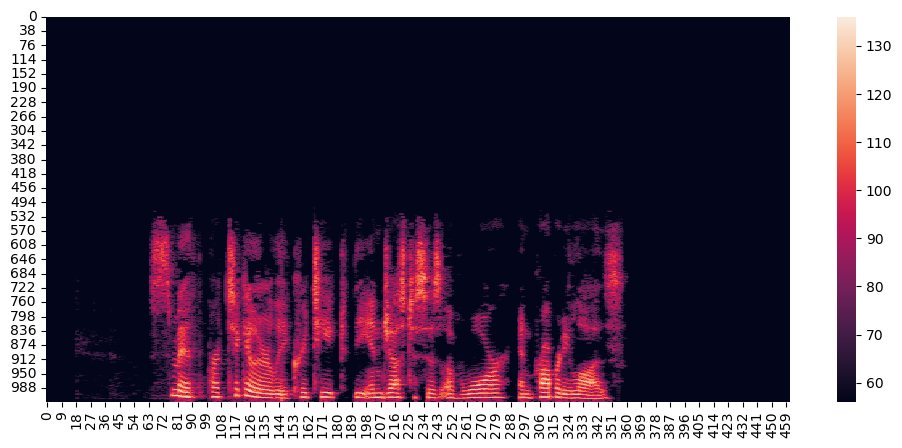

In [12]:
sns.heatmap(np.flip(librosa.amplitude_to_db(abs(X),ref=np.min), axis =0))

To plot as individual line charts in one view:

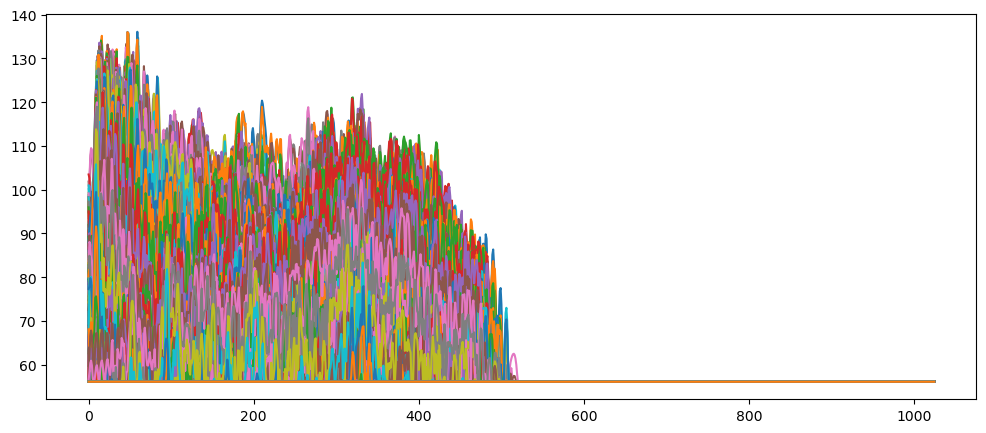

In [13]:
plt.plot(librosa.amplitude_to_db(np.abs(X),ref=np.min))
plt.show()

To plot the individal frequency 

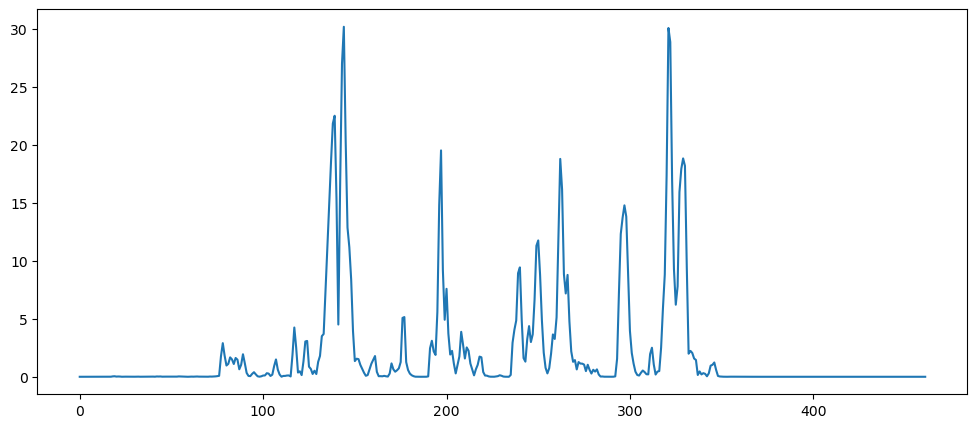

In [14]:
plt.plot(abs(X[20]))
plt.show()

## Spectrogram

We can plot the magnitude of the STFT, in decible unit, that is the sprectrogram for the signal. librosa provide a helper function "display.specshow" to plot matrix.

(1025, 462) <class 'numpy.ndarray'> <class 'numpy.float32'>


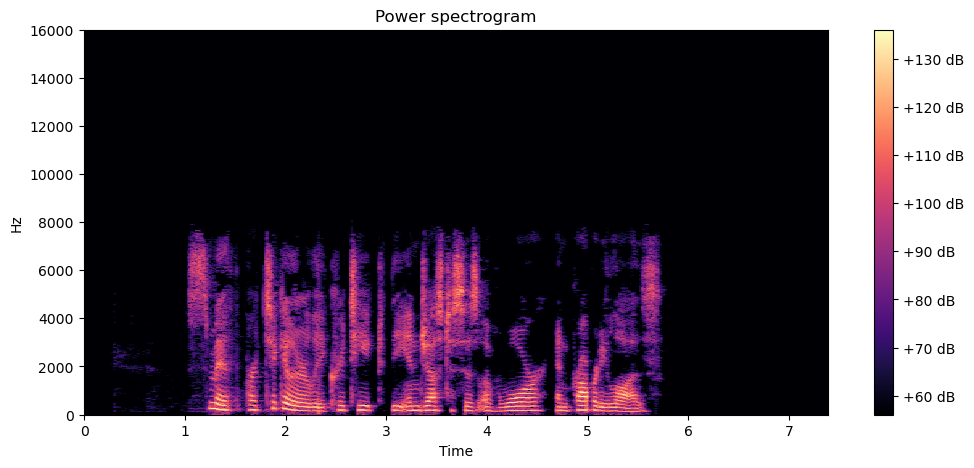

In [22]:
x, sr = librosa.load(data_dir+audiofile[4],sr=None) 
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X),ref=np.min)
print(Xdb.shape, type(Xdb), type(Xdb[0,0]))
fig, ax = plt.subplots()
img = librosa.display.specshow(Xdb, sr = sr, x_axis='time', y_axis='hz')
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()


Recall we can compute the fundamental frequency and plot the voiced vs. unvoiced segments. Observe how the voiced segments lined up with the spectragram plot.

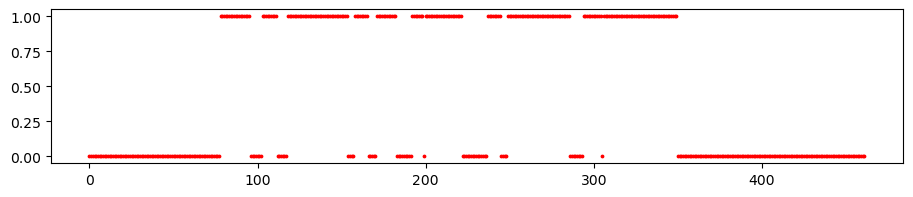

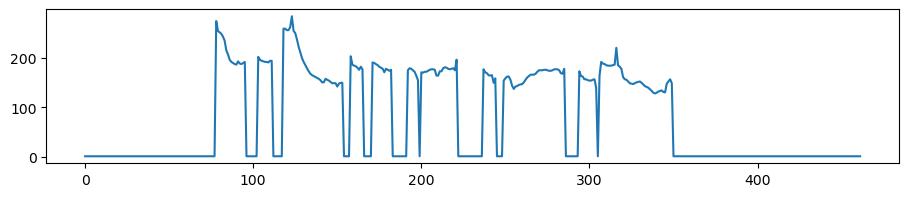

In [15]:
x, sr = librosa.load(data_dir+audiofile[4],sr = None) 
f0, voiced_flag, voiced_probs = librosa.pyin(
    x,sr=sr, fmin=50, fmax=1000, fill_na=True)
plt.figure(figsize=(11, 2))
plt.scatter(range(voiced_flag.shape[0]),voiced_flag*1, s=3,color = "r")
plt.show()
plt.figure(figsize=(11, 2))
plt.plot(f0)
plt.show()

In [24]:
print(f0.shape, voiced_flag.shape, voiced_probs.shape, x.shape[0]/f0.shape[0])
voiced_flag[70:95], f0[75:95]

(462,) (462,) (462,) 511.16883116883116


(array([False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]),
 array([  1.        ,   1.        ,   1.        , 274.79072949,
        254.91212546, 251.98420998, 249.08992447, 243.40070273,
        235.10958126, 215.59643661, 207.05298477, 196.56411971,
        192.07458901, 189.86842419, 187.68759933, 186.60659831,
        193.18726578, 188.77486254, 187.68759933, 189.86842419]))

we can also show spetragram in other scales on y-axis: log, mel, linear.

converting a frequency in hertz into m mels (in mel scale):

$m = 2595 \ log_{10} (1+\frac{f}{700)})$

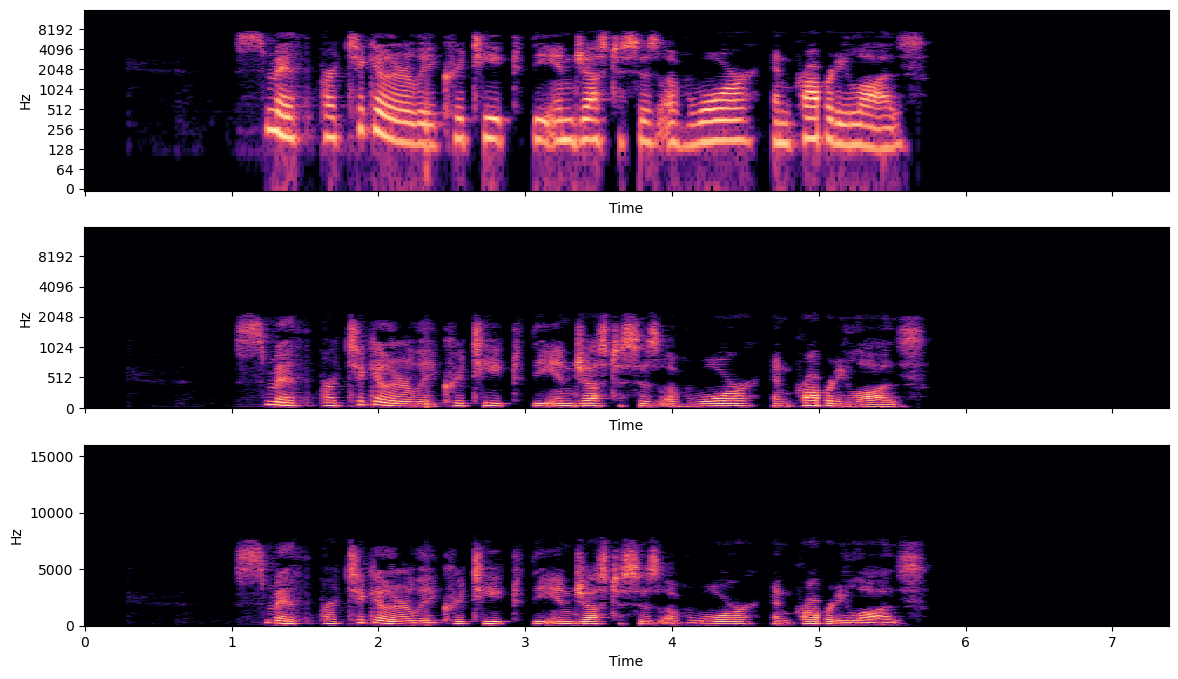

In [25]:
x, sr = librosa.load(data_dir+audiofile[4],sr=None) 
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X),ref=np.min)

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (14,8))

librosa.display.specshow(Xdb, sr = sr, x_axis='time', y_axis='log', ax=ax[0])
librosa.display.specshow(Xdb, sr = sr, x_axis='time', y_axis='mel', ax=ax[1])
librosa.display.specshow(Xdb, sr = sr, x_axis='time', y_axis='linear', ax=ax[2])
plt.show()

## melspectrogram

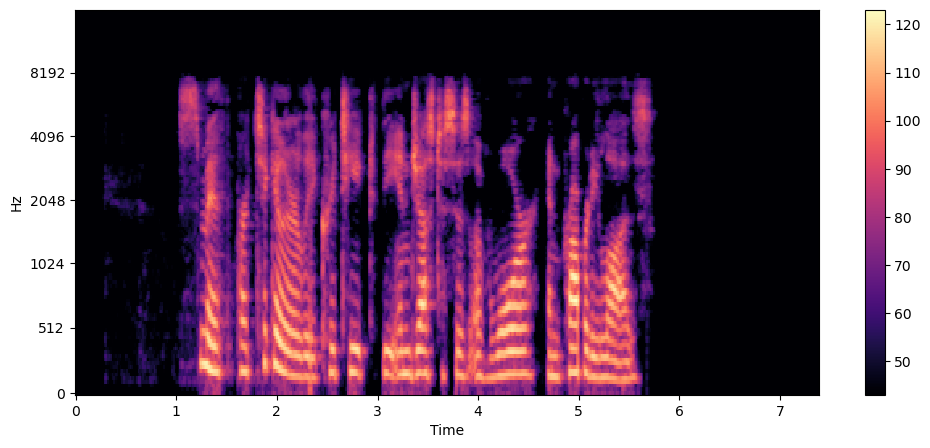

In [26]:
x, sr = librosa.load(data_dir+audiofile[4], sr = None)
S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=sr/2)

Sdb = librosa.power_to_db(S, ref=np.min)
librosa.display.specshow(Sdb,  sr=sr, y_axis = "mel", x_axis = 'time',fmax=sr/2)
plt.colorbar()


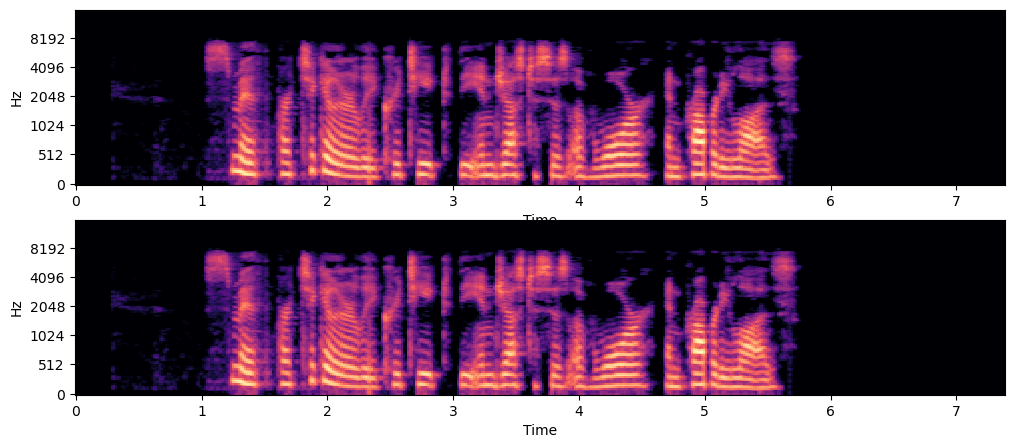

In [27]:
x, sr = librosa.load(data_dir+audiofile[4], sr = None)

fig, ax = plt.subplots(2,1)

S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=sr/2)
Sdb = librosa.power_to_db(S, ref=np.min)
librosa.display.specshow(Sdb,  sr=sr, y_axis = "mel", x_axis = 'time',fmax=sr/2,ax=ax[0])

D = np.abs(librosa.stft(x))**2
S_from_D = librosa.feature.melspectrogram(S=D, sr=sr, n_mels = 128,fmax=sr/2)
Sdb_from_D = librosa.power_to_db(S_from_D, ref=np.min)

librosa.display.specshow(Sdb_from_D,  sr=sr, y_axis = "mel", x_axis = 'time',fmax=sr/2,ax=ax[1])
plt.show()


In [28]:
np.array_equal(Sdb, Sdb_from_D)

True

In [29]:
np.equal(Sdb, Sdb_from_D).sum(), S.shape[0]*S.shape[1]

(59136, 59136)

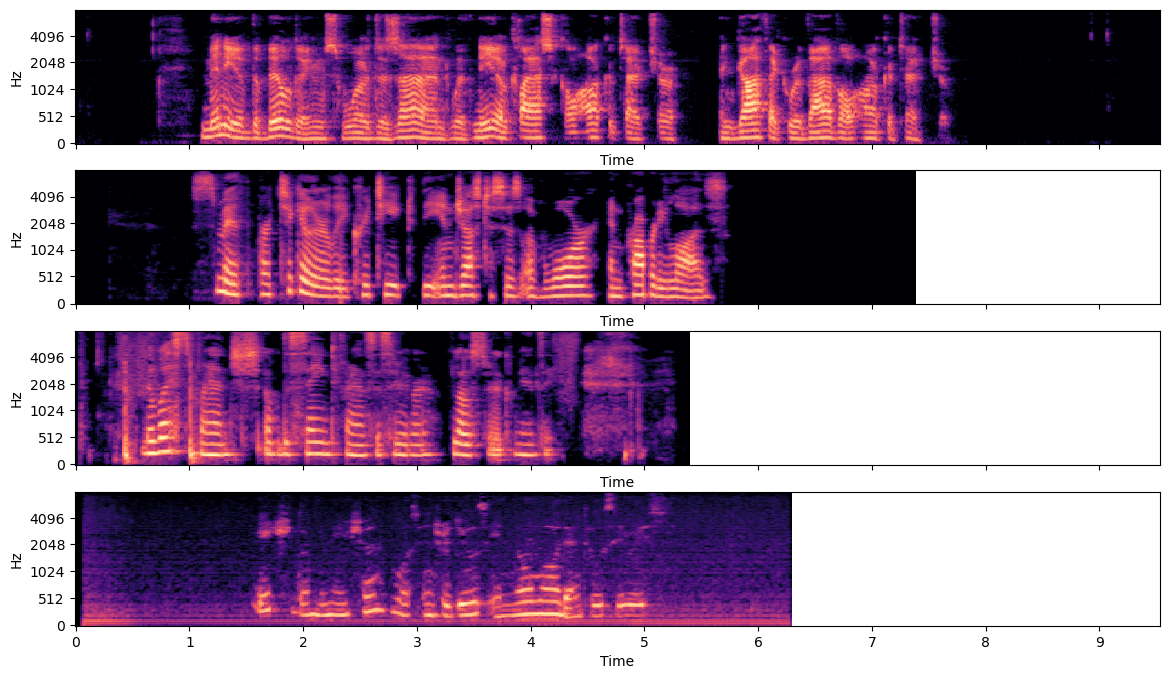

In [30]:
x1, sr1 = librosa.load(data_dir+audiofile[3], sr = None)
x2, sr2 = librosa.load(data_dir+audiofile[4], sr = None)
x3, sr3 = librosa.load(data_dir+audiofile[5], sr = None)
x4, sr4 = librosa.load(data_dir+audiofile[7], sr = None)

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize = (14,8))


S1 = librosa.feature.melspectrogram(y=x1, sr=sr1, n_mels=128, fmax=8000)
S1_dB = librosa.power_to_db(S1, ref=np.min)
img1 = librosa.display.specshow(S1_dB,  sr=sr1, y_axis = "mel", x_axis = 'time',
                        fmax=8000,ax=ax[0])
S2 = librosa.feature.melspectrogram(y=x2, sr=sr2, n_mels=128, fmax=8000)
S2_dB = librosa.power_to_db(S2, ref=np.min)
img2 = librosa.display.specshow(S2_dB, sr=sr2, y_axis = "mel", x_axis = 'time',
                        fmax=8000,ax=ax[1])
S3 = librosa.feature.melspectrogram(y=x3, sr=sr3, n_mels=128, fmax=8000)
S3_dB = librosa.power_to_db(S3, ref=np.min)
img3 = librosa.display.specshow(S3_dB,  sr=sr3, y_axis = "mel", x_axis = 'time',
                        fmax=8000,ax=ax[2])
S4 = librosa.feature.melspectrogram(y=x4, sr=sr4, n_mels=128, fmax=8000)
S4_dB = librosa.power_to_db(S4, ref=np.min)
img4 = librosa.display.specshow(S4_dB, sr=sr4, y_axis = "mel", x_axis = 'time',
                        fmax=8000,ax=ax[3])

More ways to display spectrograms.

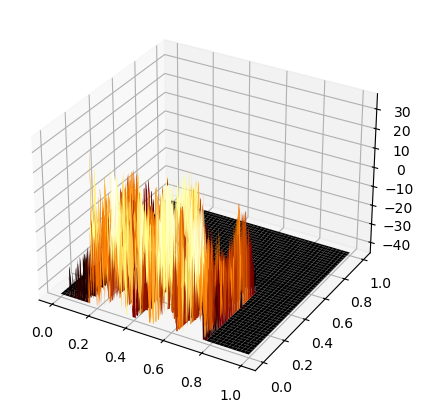

In [31]:
x, sr = librosa.load(data_dir+audiofile[4],sr=None) 
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ny, nx = abs(X).shape
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
xx,yy = np.meshgrid(x,y)
ax.plot_surface(xx,yy,Xdb,cmap='afmhot',linewidth=0)
plt.show()

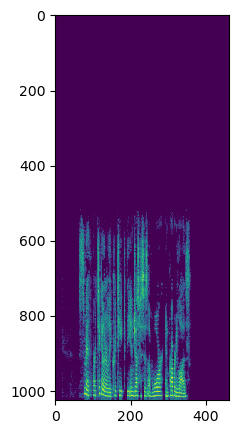

In [32]:
plt.imshow(np.flip(Xdb,axis=0), interpolation='none')

## MFCC (Mel-frequency cepstral coefficients)

librosa provide a function to compute mfcc, the input can be the singal data of a voice, or the spectrogram of the signal. 

librosa.feature.mfcc(*, y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)[source]

n_mfcc specifies the number of number of the cepstral coefficients desired to be returned, default is 20, there have been research demonstrating that 25 might be the optimal number of coefficients for more of the speach data analysis tasks. 


In [33]:
x, sr = librosa.load(data_dir+audiofile[4],sr = None)
mfcc = librosa.feature.mfcc(y=x, sr=sr)
print(mfcc.shape)


(20, 462)


### MFCC

FFT => abs() => log() => DCT


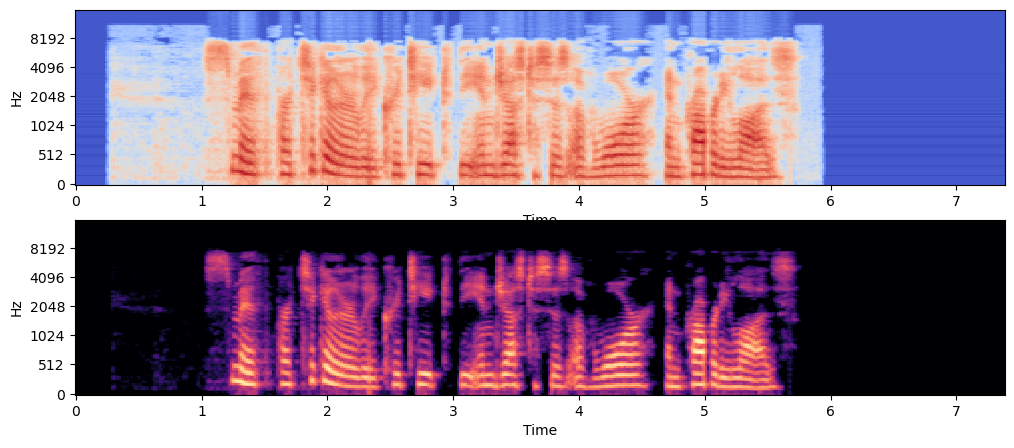

In [34]:
x, sr = librosa.load(data_dir+audiofile[4],sr = None)
X = librosa.stft(y=x)
S_from_D = librosa.feature.melspectrogram(S=librosa.power_to_db(abs(X)),sr = sr, n_mels = 128, fmax =sr/2)

S = librosa.feature.melspectrogram(y=x, sr=sr,n_mels = 128,fmax=sr/2)
Sdb = librosa.power_to_db(S, ref=np.min)
fig, ax = plt.subplots(2,1)
librosa.display.specshow(S_from_D,  sr=sr, y_axis = "mel", x_axis = 'time',fmax=sr/2,ax=ax[0])
librosa.display.specshow(Sdb,  sr=sr, y_axis = "mel", x_axis = 'time',fmax=sr/2,ax=ax[1])


MFCC can be computed in librosa either from the original signal, or from the log power of melspectrogram.

In [35]:
x, sr = librosa.load(data_dir+audiofile[4],sr = None)
x_mfcc = librosa.feature.mfcc(y=x,sr=sr,n_mfcc=25,n_mels = 128, dct_type=2)

S = librosa.feature.melspectrogram(y=x, sr=sr,n_mels = 128,fmax=sr/2)
S_mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S),sr=sr,n_mfcc=25, n_mels = 128,dct_type=2)
np.array_equal(x_mfcc, S_mfcc)

True

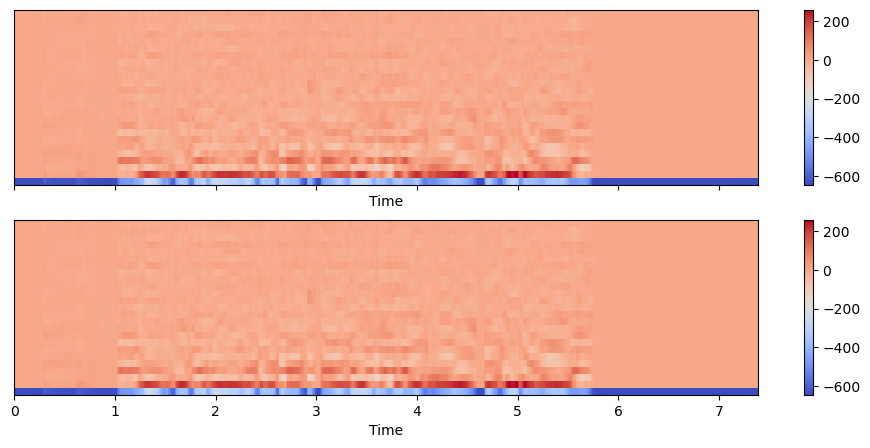

In [36]:
fig, ax = plt.subplots(nrows=2, sharex=True,sharey=True)
img1 = librosa.display.specshow(x_mfcc, sr = sr, x_axis='time', ax=ax[0])
fig.colorbar(img1, ax = [ax[0]])
img2 = librosa.display.specshow(S_mfcc, sr = sr, x_axis='time',ax=ax[1])
fig.colorbar(img2, ax = [ax[1]])

In [37]:
x_mfcc

array([[-644.23627, -644.23627, -644.23627, ..., -644.23627, -644.23627,
        -644.23627],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

we can take the stats of mfcc over time domain, and 

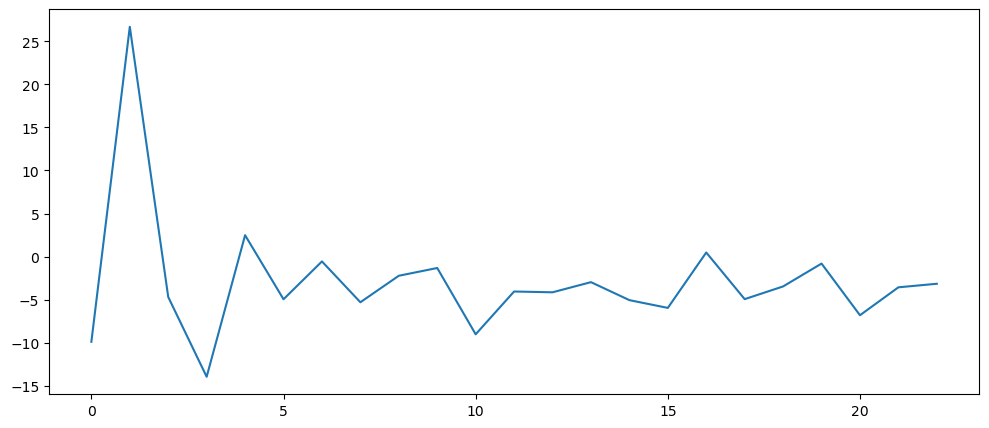

In [38]:
x_mfcc_mean = x_mfcc.mean(axis=1)
plt.plot(x_mfcc_mean[2:])


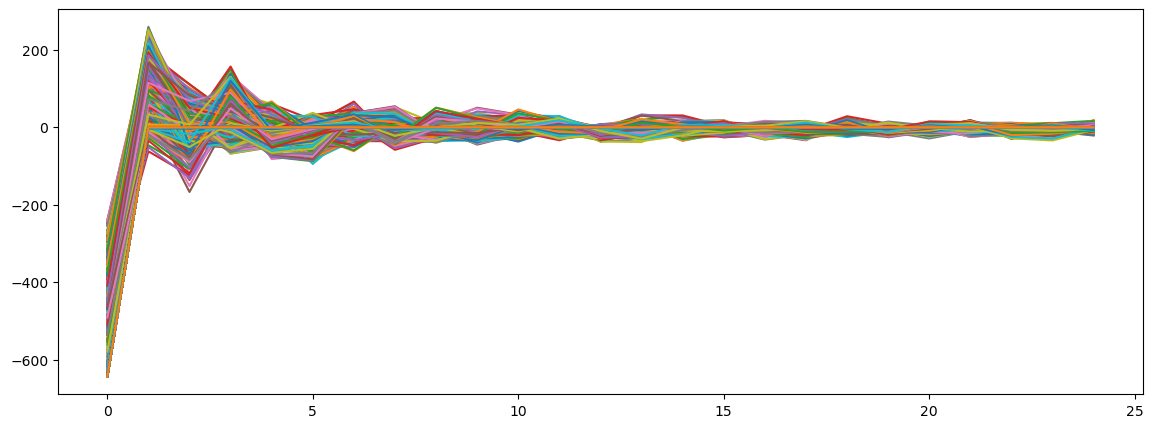

In [39]:
plt.figure(figsize=(14, 5))
plt.plot(x_mfcc)
plt.show()

In [40]:
mfcc_mean = x_mfcc.mean(axis=1)
mfcc_mean

array([-4.9097510e+02,  8.6960381e+01, -9.8929482e+00,  2.6688948e+01,
       -4.6908307e+00, -1.3958532e+01,  2.4826920e+00, -4.9558506e+00,
       -5.6138253e-01, -5.3043890e+00, -2.2267275e+00, -1.3251647e+00,
       -9.0248623e+00, -4.0548377e+00, -4.1478820e+00, -2.9691331e+00,
       -5.0575323e+00, -5.9601846e+00,  4.7541952e-01, -4.9420362e+00,
       -3.4656255e+00, -8.1088841e-01, -6.8101144e+00, -3.5689735e+00,
       -3.1556153e+00], dtype=float32)

## which sampling rate to use

showing that voice clip voice_clip_meta_data.iloc[115].path, 'common_voice_en_26324576.mp3' is rendered entirely unvoiced if we use librosa default sample rate. 

In [41]:
voice_clip_meta_data.iloc[115]

client_id      019c3f021276100121bb5b2b265058cfdb912fd8496492...
path                                common_voice_en_26324576.mp3
sentence_id    979555619c26c0fdc3900ea04dbcb8406ce59dbfe54c9f...
sentence                    They are part of the Inner Hebrides.
up_votes                                                       2
down_votes                                                     0
age                                                     thirties
gender                                            male_masculine
accents                                    United States English
Name: 115, dtype: object

In [42]:
Audio(data_dir+voice_clip_meta_data.iloc[115].path)

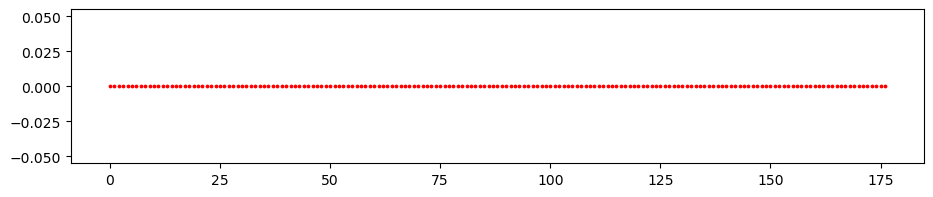

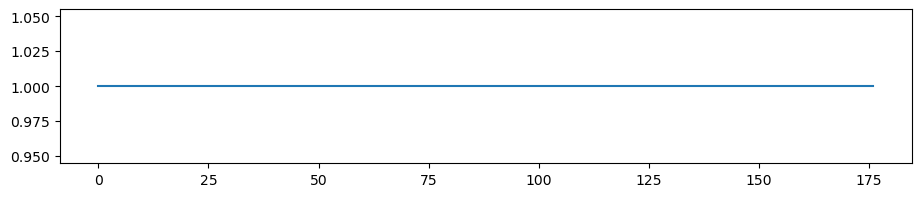

In [43]:
x, sr = librosa.load(data_dir+voice_clip_meta_data.iloc[115].path) # resampled to 22050 by librosa default
f0, voiced_flag, voiced_probs = librosa.pyin(
    x,sr=sr, fmin=50, fmax=1000, fill_na=True)
plt.figure(figsize=(11, 2))
plt.scatter(range(voiced_flag.shape[0]),voiced_flag*1, s=3,color = "r")
plt.show()
plt.figure(figsize=(11, 2))
plt.plot(f0)
plt.show()

In [44]:
voiced_flag.sum()

0

In [45]:
x, sr = librosa.load(data_dir+voice_clip_meta_data.iloc[115].path,sr=None) # native sample rate
print(sr, get_f0_stats(x,sr)) # matching sample rate
x, sr = librosa.load(data_dir+voice_clip_meta_data.iloc[115].path) # resampled to 22050 by librosa default
print(sr, get_f0_stats(x,sr)) # default 22050
x, sr = librosa.load(data_dir+audiofile[4],sr=None) #native sample rate
print(sr, get_f0_stats(x,sr=22050)) # mismatch sample rate, the clip has sample rate 32000


32000 [93.49208242223375, 13.13603398912084, 0.35089497051495044, -1.4437582416366617]
22050 [nan, nan, nan, nan]
32000 [121.05364048201304, 402.34893503972097, 1.3036370778921273, 2.200280173424493]


In [32]:
clip, sr = librosa.load(data_dir+voice_clip_meta_data.iloc[11].path, sr=None)
rate = librosa.feature.zero_crossing_rate(clip, frame_length = 2048, hop_length=512, center=True)

In [33]:
rate

array([[0.04052734, 0.06494141, 0.09179688, 0.09765625, 0.11376953,
        0.11572266, 0.12158203, 0.13964844, 0.16113281, 0.19775391,
        0.22363281, 0.22851562, 0.23046875, 0.21875   , 0.21435547,
        0.21728516, 0.21923828, 0.21972656, 0.22119141, 0.21777344,
        0.19189453, 0.17480469, 0.15625   , 0.140625  , 0.14501953,
        0.13867188, 0.13769531, 0.13623047, 0.13232422, 0.14013672,
        0.13574219, 0.13085938, 0.12646484, 0.11865234, 0.11572266,
        0.109375  , 0.10546875, 0.09912109, 0.09716797, 0.09570312,
        0.10253906, 0.11230469, 0.11132812, 0.10986328, 0.10400391,
        0.10888672, 0.12060547, 0.13232422, 0.14501953, 0.14160156,
        0.13818359, 0.13769531, 0.1328125 , 0.125     , 0.12207031,
        0.11328125, 0.09960938, 0.10205078, 0.09814453, 0.09716797,
        0.1015625 , 0.09423828, 0.08544922, 0.07763672, 0.08398438,
        0.08105469, 0.08251953, 0.08837891, 0.08300781, 0.09814453,
        0.12890625, 0.16259766, 0.19238281, 0.20

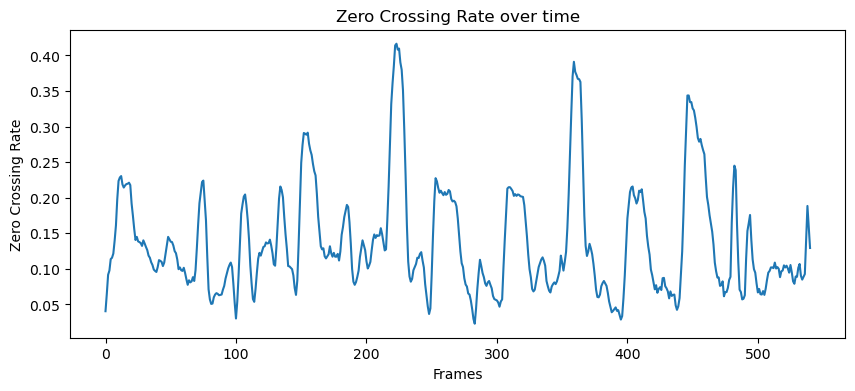

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(rate[0])
plt.xlabel('Frames')
plt.ylabel('Zero Crossing Rate')
plt.title('Zero Crossing Rate over time')
plt.show()